# Collaboration and Competition with DDPG and Tennis
_________________________

## Imports

In [1]:
import copy
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from unityagents import UnityEnvironment
from collections import namedtuple, deque

## Unity environment & Info

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

# get the default brain
wimbledon = env.brain_names[0]
brain = env.brains[wimbledon]

env_info = env.reset(train_mode=True)[wimbledon]

action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

num_agents = len(env_info.agents)
print('Number of agents: {}'.format(num_agents))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2


## Hyperparameters

In [3]:
BUFFER_SIZE = int(1e6)     # replay buffer size
BATCH_SIZE = 1024            # minibatch size
GAMMA = 0.99               # discount factor
TAU = 1e-3                 # for soft update of target parameters
LR_ACTOR = 3e-4            # learning rate of the actor 
LR_CRITIC = 3e-3           # learning rate of the critic
update_every = 20           # number of timesteps after which to run an update
SN = 0.5                   # starting value for additive noise scale (exploratory actions)
ND = 0.999                 # noise decay rate (exploratory actions)
NM = 0.1                  # noise minimum to be maintained (exploratory actions)
UC = 10                     # Number of cycles to run updates for

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## DDPG agents
____
### Define Actor and Critic architectures

In [4]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hu=(256, 128),
                 activ_in = F.relu, activ_out = torch.tanh):
        super(Actor, self).__init__()
        
        self.activ_in = activ_in
        self.activ_out = activ_out
        
        self.input_layer = nn.Linear(state_size, hu[0])
        self.bn1 = nn.BatchNorm1d(hu[0])
        self.hl1 = nn.Linear(hu[0], hu[1])
        self.bn2 = nn.BatchNorm1d(hu[1])
        self.output_layer = nn.Linear(hu[-1], action_size)
        self.bn3 = nn.BatchNorm1d(action_size)
        
    def forward(self, state):
        x = state
        x = self.activ_in(self.input_layer(x))
        x = self.bn1(x)
        x = self.activ_in(self.hl1(x))
        x = self.bn2(x)
        x = self.output_layer(x)
        x = self.bn3(x)
        return self.activ_out(x)
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hu=(256, 128), activ_in = F.leaky_relu):
        super(Critic, self).__init__()
        
        self.activ_in = activ_in
        
        self.bn0 = nn.BatchNorm1d(state_size)
        self.input_layer = nn.Linear(state_size, hu[0])
        self.bn1 = nn.BatchNorm1d(hu[0])
        self.hl1 = nn.Linear(hu[0]+action_size, hu[1])
        self.bn2 = nn.BatchNorm1d(hu[1])
        self.output_layer = nn.Linear(hu[-1], 1)
        
    def forward(self, state, action):
        state = self.bn0(state)
        xs = self.input_layer(state)
        xs = self.bn1(xs)
        xs = self.activ_in(xs)
        x = torch.cat((xs, action), dim=1)
        x = self.hl1(x)
        x = self.bn2(x)
        x = self.activ_in(x)
        return self.output_layer(x)

### Define DDPG agent & methods

In [34]:
class DDPG_agent():
    def __init__(self, state_size, action_size, num_agents=2, batch_size=BATCH_SIZE,
                 start_noise=SN, noise_decay=ND, noise_min=NM, add_noise=True, update_cycles=UC):
        super(DDPG_agent, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.batch_size = batch_size
        
        ### Initialise actor online and target networks
        self.actor_online = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_online.parameters(), lr=LR_ACTOR)
        
        ### Initialise critic online and target networks
        self.critic_online = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_online.parameters(), lr=LR_CRITIC)
        
        ### Ensure actor and online networks start off with same parameters
        self.equalize_OnlineTarget(self.actor_target, self.actor_online)
        self.equalize_OnlineTarget(self.critic_target, self.critic_online)
        
        ### Noise parameters for exploration
        self.noise_scale = start_noise
        self.noise_decay = noise_decay
        self.noise_min = noise_min
        self.add_noise = add_noise
        
        self.update = 0
        self.update_cycles = update_cycles
        
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)

        
    def equalize_OnlineTarget(self, target, online):
        for target_param, online_param in zip(target.parameters(), online.parameters()):
            target_param.data.copy_(online_param.data)
            
    def generate_noise(self):
        noise = np.random.normal(loc=0, scale=self.noise_scale, size=self.action_size)
        self.noise_scale = max(self.noise_decay*self.noise_scale, self.noise_min)
        return noise
    
    def act(self, state):
        state = torch.from_numpy(state).float().to(device)

        self.actor_online.eval()
        with torch.no_grad():
            action = self.actor_online(state).cpu().data.numpy()

        self.actor_online.train()

        if self.add_noise:
            for i in range(self.num_agents):
                agent_action = action[i]
                for j in agent_action:
                    j += self.generate_noise()
        return np.clip(action, -1, 1)
    
    def soft_update(self, online_model, target_model, tau):
        for target_param, online_param in zip(target_model.parameters(), online_model.parameters()):
            target_param.data.copy_(tau*online_param.data + (1.0-tau)*target_param.data)
            
    def step(self, state, action, reward, next_state, done):    
        self.memory.add(state, action, reward, next_state, done, self.num_agents)
        
        self.update = (self.update+1)%update_every
        
        if (self.update==0):
            if len(self.memory) > self.batch_size:
                for _ in range(self.update_cycles):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)
                
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        Q_expected = self.critic_online(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_online.parameters(), 1)
        self.critic_optimizer.step()
        
        
        actions_pred = self.actor_online(states)
        actor_loss = -self.critic_online(states, actions_pred).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        self.soft_update(self.critic_online, self.critic_target, TAU)
        self.soft_update(self.actor_online, self.actor_target, TAU)
        
    def save_checkpoint(self, path):
        print("Model Save...")
        torch.save(self.actor_online.state_dict(), '{}_checkpoint_actor.pth'.format(path))
        torch.save(self.critic_online.state_dict(), '{}_checkpoint_critic.pth'.format(path))
        
    def load_checkpoint(self, path):
        agent.actor_online.load_state_dict(torch.load('{}_checkpoint_actor.pth'.format(path)))
        agent.critic_online.load_state_dict(torch.load('{}_checkpoint_critic.pth'.format(path)))

### Define ReplayBuffer

In [28]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.memory = deque(maxlen=self.buffer_size)

    def add(self, state, action, reward, next_state, done, num_agents):
        """Add a new experience to memory."""
        for i in range(num_agents):
            e = self.experience(state[i], action[i], reward[i], next_state[i], done[i])
            self.memory.append(e)      

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Instantiate agent

In [35]:
agent = DDPG_agent(state_size=state_size, action_size=action_size, num_agents=2)

### Define training function

In [8]:
def train_DDPG(path, n_episodes=2500, train=True, overtrain=True):
    scores_deque = deque(maxlen=100)
    scores = []
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train)[wimbledon]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(2)                          # initialize the score (for each agent)
        
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[wimbledon]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states                               # roll over states to next time step
            score += rewards                                  # update the score (for each agent)            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        
        if i_episode%100:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tMin: {:.2f}\tMax: {:.2f}'.format(i_episode, np.mean(scores_deque), np.max(score), np.min(scores_deque), np.max(scores_deque)), end="")
        else:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tMin: {:.2f}\tMax: {:.2f}'.format(i_episode, np.mean(scores_deque), np.max(score), np.min(scores_deque), np.max(scores_deque)), end="\n")
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            agent.save_checkpoint(path)
            break
        
    return scores

___________________
## Train & save checkpoint to *path*

In [9]:
scores = train_DDPG(path='Model Checkpoints/06042020_#1')

Episode 100	Average Score: 0.02	Score: 0.00	Min: 0.00	Max: 0.10
Episode 200	Average Score: 0.00	Score: 0.00	Min: 0.00	Max: 0.10
Episode 300	Average Score: 0.05	Score: 0.00	Min: 0.00	Max: 0.60
Episode 400	Average Score: 0.08	Score: 0.00	Min: 0.00	Max: 0.20
Episode 500	Average Score: 0.09	Score: 0.10	Min: 0.00	Max: 0.19
Episode 600	Average Score: 0.05	Score: 0.00	Min: 0.00	Max: 0.30
Episode 700	Average Score: 0.02	Score: 0.20	Min: 0.00	Max: 0.20
Episode 800	Average Score: 0.09	Score: 0.10	Min: 0.00	Max: 0.30
Episode 900	Average Score: 0.15	Score: 0.20	Min: 0.00	Max: 0.60
Episode 1000	Average Score: 0.35	Score: 0.50	Min: 0.00	Max: 1.99
Episode 1100	Average Score: 0.58	Score: 0.60	Min: 0.10	Max: 2.60
Episode 1200	Average Score: 0.48	Score: 0.50	Min: 0.09	Max: 2.30
Episode 1262	Average Score: 0.75	Score: 2.60	Min: 0.09	Max: 2.60
Environment solved in 1162 episodes!	Average Score: 0.75
Model Save...


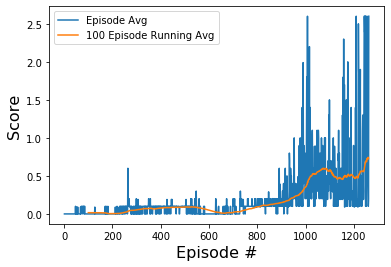

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label='Episode Avg')
plt.ylabel('Score', fontsize=16);
plt.xlabel('Episode #', fontsize=16);
plt.plot(range(100, len(scores)),[np.average(scores[i-100:i]) for i in range(100, len(scores))],label='100 Episode Running Avg');
plt.legend();
plt.show();

_________________________
## Watch a trained agent

### Load model
You can watch the agent just trained, load my own pre-trained model (included in the repo and default below) to watch my agent, or load your own checkpoints.

In [36]:
agent.load_checkpoint(path='Model Checkpoints/06042020_#1')

### Watch the agent

In [37]:
env_info = env.reset(train_mode=False)[wimbledon]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)
    env_info = env.step(actions)[wimbledon]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 1.1950000179931521
